In [13]:
from collections import Counter, namedtuple, defaultdict
from pprint import pprint
from itertools import groupby, permutations
from copy import deepcopy
import re

import matplotlib.pyplot as plt
from Bio import SeqIO

from vdj_walker import *

%matplotlib inline

In [70]:
"""Define constants"""
KMER_LEN = 7
PAIR_TRESHOLD = 15
COOL_TRESHOLD = 25
IMP_TRESHOLD = 10

"""Define data types"""
D = namedtuple('D', ['gene', 'J_gene', 'V_gene'])
Comb = namedtuple('Comb', ['gene', 'pos'])
DGene = namedtuple('DGene', ['read', 'gene'])
Kmer = namedtuple('Kmer', ['seq', 'j', 'v', 'dataset'])


#################################################### READING
def get_fa_header_value(line, *, index):
    return line.split('|')[index].split(':')[1]

def read_fa(file):
    for record in SeqIO.parse(file, 'fasta'):
        yield str(record.seq)

def read_J(file):
    for record in SeqIO.parse(file, 'fasta'):
        id_ = get_fa_header_value(record.id, index=1)
        if id_.startswith('cluster'):
           seq_len = len(str(record.seq).replace('-', ''))
        else:
            yield Comb(id_, seq_len)

def read_genes(file):
    for record in SeqIO.parse(file, 'fasta'):
        gene = record.id
        read = str(record.seq).upper()
        yield DGene(read, gene)

def read_V_headers(file):
    length = 0
    for record in SeqIO.parse(file, 'fasta'):
        if 'READ' in record.id:
            length = int(get_fa_header_value(record.id, index=3))
        elif 'GENE' in record.id:
            gene = get_fa_header_value(record.id, index=1)
            yield Comb(gene, length)

def split_kmers(read, size):
    for i in range(len(read) - size + 1):
        kmer = read[i : i + size]
        yield kmer

def read_info(csv):
    for line in csv:
        atrs = line.split()
        v = Comb(atrs[4], int(atrs[2]) - 1)
        j = Comb(atrs[8], int(atrs[5]) - 1)
        yield (v, j)

def fetch_d(vdj_dir: Path, i):
    clean_reads = read_fa(open(vdj_dir / 'cleaned_reads.fasta', 'r'))
    info = read_info(open(vdj_dir / 'alignment_info.csv'))
    
    for read, (v, j) in zip(clean_reads, info):
        d_read = read[v.pos + 1 : j.pos]
        yield (d_read, (j.gene, v.gene, i))

def read_iter():
    for i, vdj_dir in enumerate(vdj_dir_iter()):
        for read, info in fetch_d(vdj_dir, i):
            yield (read, info)

            
#################################################### KMER CLEANING
def read_imp(read):
    for kmer in split_kmers(read, KMER_LEN):
        if kmer not in ds_kmers:
            if kmer in good:
                yield kmer_pairs[kmer]
            else:
                yield 0
        else:
            yield kmer_pairs[kmer]

def is_good(n):
    return n >= IMP_TRESHOLD


#################################################### READ
def split_read(read):
    global bad_counter, distribution, max_seq_counter
    
    read_map = list(enumerate(map(is_good, read_imp(read))))
    
    for i, imp_id in read_map:
        distribution[i][int(imp_id)] += 1
        
    bad_counter += len(list(filter(lambda x: not x[1], read_map)))
    
    gb = groupby(read_map, lambda x: x[1])
    gb = list(map(lambda x: (x[0], list(x[1])), gb))
    max_good_seq = 0
    for ids in filter(lambda x: x[0], gb):
        ids = list(map(lambda x: x[0], ids[1]))
        max_good_seq = max(max_good_seq, len(ids))
        yield read[ids[0]:(ids[-1] + KMER_LEN)]
    if max_good_seq > 0:
        max_seq_counter[max_good_seq] += 1


def merge_pairs():
    """Merge pairs"""
    global cleaned_reads
    deleted = set()
    for seg1, seg2 in permutations(cleaned_reads.keys(), 2):
        if any(seg in deleted for seg in (seg1, seg2)):
            continue
        if seg2 in seg1:
            cleaned_reads[seg1] += cleaned_reads[seg2]
            del cleaned_reads[seg2]
            deleted.add(seg2)
    return

def clean_vj():
    for read, infos in cleaned_reads.items():
        bad = set()
        for info, n in infos.items():
            if n < 15:
                bad.add(info)
        for info in bad:
            infos.pop(info)

In [15]:
#################################################### KMER OPS
"""Kmers in known D segments"""
Ds = list(read_genes(open(gene_dir / 'IGHD-allP.fa', 'r')))
l = 0
n = 0
ds_kmers = set()
for i in Ds:
    l += len(i.read)
    n += 1
    for kmer in split_kmers(i.read, KMER_LEN):
        ds_kmers.add(kmer)
print(l / n)

24.318181818181817


In [10]:
#################################################### READ OPS
"""Cut D segments from all datasets"""
raw_kmers = Counter()
for read, info in read_iter():
    for seq in split_kmers(read, KMER_LEN):
        raw_kmers[Kmer(seq, *info)] += 1
print('Raw kmers:', len(raw_kmers))

"""Count kmer pairs and delete kmers with less than PAIR_TRESHOLD number of occurences"""
kmer_pairs = Counter()
for kmer, n in raw_kmers.items():
    if n > PAIR_TRESHOLD:
        kmer_pairs[kmer.seq] += 1
print('Paired kmers:', len(kmer_pairs))

"""Filter kmers with small number of pairs"""
good = set()
for kmer, n in kmer_pairs.items():
    if n >= 20:
        good.add(kmer)
print('Good kmers:', len(good))

"""Filter kmers with small number of pairs"""
cool = set()
for kmer, n in kmer_pairs.items():
    if kmer not in ds_kmers and n >= COOL_TRESHOLD:
        cool.add(kmer)
print('Cool kmers:', len(cool))

Raw kmers: 3039905
Paired kmers: 8350
Good kmers: 211
Cool kmers: 14


In [47]:
"""Clean trash from d segments"""
bad_counter = 0
cleaned_reads = defaultdict(Counter)
before_len = Counter()
after_len = Counter()
distribution = [[0, 0] for _ in range(200)]
max_seq_counter = Counter()

for read, info in read_iter():
    before_len[len(read)] += 1
    for clean_read in split_read(read):
        after_len[len(clean_read)] += 1
        cleaned_reads[clean_read][info] += 1

print(len(cleaned_reads))
print(bad_counter)

7452
5098386


In [51]:
merge_pairs()
print('Merged clean reads:', len(cleaned_reads))

Merged clean reads: 767


In [65]:
def Na():
    sa = 0
    for infos in cleaned_reads.values():
        sa += len(infos)
    return sa / len(cleaned_reads)

print(Na())
clean_vj()
print(Na())

7.704041720990873
4.1095176010430245


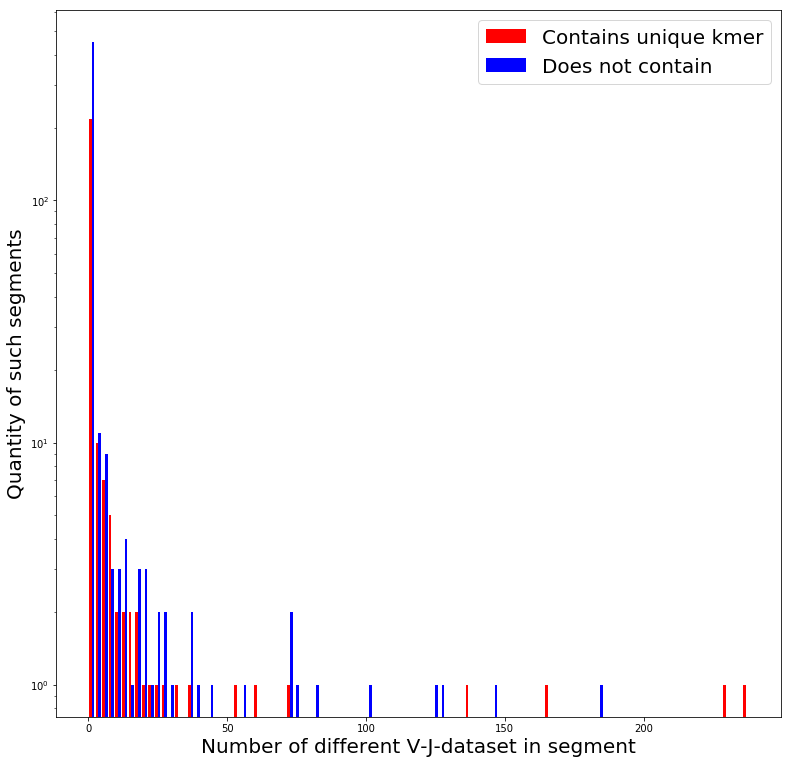

In [67]:
cleaned_plot = plt.figure(figsize=(13, 13))

def xs(cont):
    for read, infos in cleaned_reads.items():
        #if len(infos) > 1000: continue
        if any(kmer in read for kmer in cool) == cont:
            yield len(infos)

_ = plt.hist([list(xs(True)), list(xs(False))], bins=100, 
             color=['r', 'b'], log=True, label=['Contains unique kmer', 'Does not contain'])
plt.xlabel('Number of different V-J-dataset in segment', fontsize=20)
plt.ylabel('Quantity of such segments', fontsize=20)
plt.legend(fontsize=20)

In [63]:
cleaned_plot.savefig('cleaned3.png')

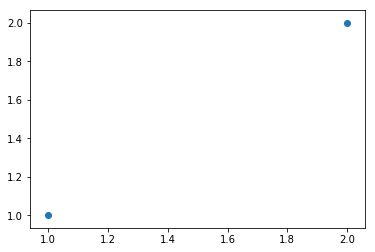

In [72]:
x = []
y = []
for read, infos in cleaned_reads.items():
    x.append(len(infos))
    y.append(len(read))



In [68]:
comb_reads = defaultdict(list)
for read, triples in cleaned_reads.items():
    if len(set(map(lambda x: x[2], triples))) < 2:
        continue
        
    comb = tuple(kmer for kmer in cool if kmer in read)
    #print(comb)
    if len(comb) > 1:
        comb_reads[comb].append(read)

len(comb_reads)

13